In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset

In [25]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "verbose": True,
    "n_epochs": 40,
    "lr": 0.01,
    "l2": 0.0005,
    "disable_prog_bar": True
}
end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2]
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5,
    "train_kwargs": train_kwargs
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5,
    "train_kwargs": train_kwargs
}

print("WARNING: Pay attention to slice weight!")
sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
        "reweight": True,
    },
    "train_kwargs": train_kwargs
}

sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_head_weight": 0.1,
        "Y_head_weight": 0.1 
    },
    "train_kwargs": train_kwargs
}

sm_dp_config = {
    'slice_kwargs': {
        'r': 10,
        'slice_weight': 0.1,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 10,
        'middle_dims': [10],
        'bias': True
    }
}

### Same data, multiple trials

Pepper: 0.1
Salt: 20


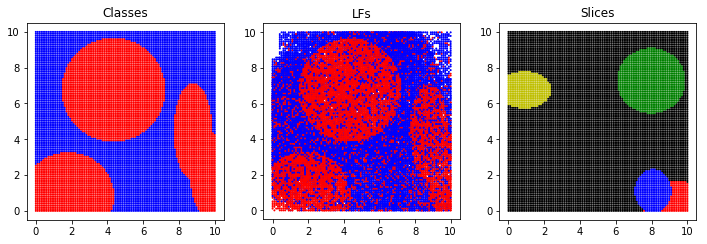

CPU times: user 5.86 s, sys: 361 ms, total: 6.22 s
Wall time: 5.92 s


In [24]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model

NUM_SLICES = 4
K = 2
M = 20
N = 10000
unipolar = False
pepper = 0.1
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 20 #np.random.randint(1e6)
print(f"Salt: {salt}")


L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
L_kwargs.update({
    "min_acc": 0.7
})
Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                 L_kwargs=L_kwargs,
                                                 Z_kwargs=Z_kwargs,
                                                 unipolar=unipolar,
                                                 return_targeting_lfs=True,
#                                                  seed=(salt + trial),
                                                 seed = salt,
                                                 plotting=True)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
L_train_raw = Ls[0].copy() # TEMP


In [29]:
from metal.contrib.slicing.utils import unipolarize

In [30]:
NUM_TRIALS = 3
model_configs = {
#     "UNI": uni_config,
#     "UP": up_config,
#     "MoE": moe_config,
    "DP": dp_config,
    'SM_DP': sm_dp_config,
    "SM_HAT": sm_hat_config,
    "SM_ON": sm_on_config,
}

history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)    
        
        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
    
        
        # Generate weak labels
        if model_name == "UNI":
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        # TODO: don't overwrite Y_train
        Ys[0] = Y_train

        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)
        
        # Train end model
        if model_name == "UNI":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == 'UP':
            # generates weighted Y_train and overwrites overwrites Ys[0] internally
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM_HAT":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="hat")
        elif model_name == "SM_ON":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="online")
        elif model_name == 'SM_DP':
            model = train_slice_dp(model_config, Ls, Xs, Ys, Zs)    
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)

        # Save results
        history[model_name].append(results)

[Trial 0]
---------- Training DP ----------
Added pepper=0.1 random negatives on 0/20 LFs
> <ipython-input-30-a997cfb833b2>(35)<module>()
-> Ls = tuple([unipolar(L) for L in Ls])
(Pdb) Ls[0]
<5000x20 sparse matrix of type '<class 'numpy.int64'>'
	with 16997 stored elements in Compressed Sparse Row format>
(Pdb) Ls[0].toarray()
array([[0, 2, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0]], dtype=int64)
(Pdb) Ls[0].shape
(5000, 20)
(Pdb) n
TypeError: 'bool' object is not callable
> <ipython-input-30-a997cfb833b2>(35)<module>()
-> Ls = tuple([unipolar(L) for L in Ls])
(Pdb) n
--Return--
> <ipython-input-30-a997cfb833b2>(35)<module>()->None
-> Ls = tuple([unipolar(L) for L in Ls])
(Pdb) Ls[0]
<5000x20 sparse matrix of type '<class 'numpy.int64'>'
	with 16997 stored elements in Compressed Sparse Row format>
(Pdb) n
TypeError: 'bool' object is not call

TypeError: 'bool' object is not callable

In [27]:
for model_name, scores in history.items():
    print (model_name)
    for s in scores:
        print (s['all']['accuracy'])

DP
0.9204
0.9204
0.9028
SM_DP
0.9632
0.96
0.9568
SM_HAT
0.9368
0.9236
0.7972
SM_ON
0.9304
0.9628
0.9416


In [28]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=3):


,DP,SM_DP,SM_HAT,SM_ON
all,0.914533,0.960000,0.885867,0.944933
slice_0,0.920354,0.965421,0.889381,0.953294
slice_1,0.948718,0.948718,0.965812,0.931624
slice_2,0.906667,0.940000,0.976667,0.980000
slice_3,0.833333,0.924779,0.766962,0.846608
slice_4,0.973597,0.953795,0.960396,0.966997
slice_avg,0.916534,0.946543,0.911843,0.935704


### Different data per trial

In [ ]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UP": up_config,
#     "MoE": moe_config,
    "DP": dp_config,
    'SM_DP': sm_dp_config,
    "SM_HAT": sm_hat_config,
    "SM_ON": sm_on_config,
}

NUM_TRIALS = 1
NUM_SLICES = 4
K = 2
M = 20
N = 10000
unipolar = False
pepper = 0.1
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 15 #np.random.randint(1e6)
print(f"Salt: {salt}")


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
    Z_kwargs = {'num_slices': NUM_SLICES}
    L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                     L_kwargs=L_kwargs,
                                                     Z_kwargs=Z_kwargs,
                                                     unipolar=unipolar,
                                                     return_targeting_lfs=True,
                                                     seed=(salt + trial),
                                                     plotting=False)

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI":
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == 'UP':
            # generates weighted Y_train and overwrites overwrites Ys[0] internally
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM_HAT":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="hat")
        elif model_name == "SM_ON":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="online")
        elif model_name == 'SM_DP':
            model = train_slice_dp(model_config, Ls, Xs, Ys, Zs)    
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

In [ ]:
for model_name, scores in history.items():
    print (model_name)
    for s in scores:
        print (s['all']['accuracy'])

In [ ]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

In [ ]:
from metal.contrib.visualization.analysis import view_label_matrix
view_label_matrix(Ls[0])